In [ ]:
! sbatch_tail -p gpu -q gpu --gres=gpu:A100:4 --cpus-per-task 20 --mem-per-gpu 80G --ntasks-per-node=4 slurm/submit.sh "predict --config config/base_v3.yml --scprint_training.noise [0.7,1.0] --scprint_training.mask_ratio [] --model.dropout 0 --data.num_workers 17 --data.force_recompute_indices True --data.weight_scaler 0 --data.test_split 0 --data.batch_size 120 --trainer.num_nodes 1 --model.expr_emb_style metacell --data.get_knn_cells True --data.metacell_mode 0 --model.expr_encoder_layers 1 --model.compress_class_dim \"{'cell_type_ontology_term_id':64,'tissue_ontology_term_id':32,'disease_ontology_term_id':32,'age_group':8,'assay_ontology_term_id':12,'self_reported_ethnicity_ontology_term_id':8,'sex_ontology_term_id':2,'organism_ontology_term_id':8,'cell_culture':2}\" --model.layers_cls [256] --ckpt_path /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_v2/czg34ita/checkpoints/last.ckpt"

In [ ]:
sbatch_tail -p gpu -q gpu --gres=gpu:1 --cpus-per-task 10 --mem-per-gpu 90G --ntasks-per-node=1 slurm/submit.sh "predict --config config/base_v3.yml --model.dropout 0 --data.num_workers 9 --data.weight_scaler 0 --data.test_split 0 --data.batch_size 60 --trainer.num_nodes 1 --trainer.logger null --model.pred_embedding ['all'] --ckpt_path ../models/ji9krimq.ckpt"

## modified the model to replace logging of an anndata to logging of dataframe parquets


In [ ]:
# set this
self.keep_all_labels_pred = True

In [ ]:
# know this:
model.classes
model.hparams["classes"](counts)
num = {
    "cell_type_ontology_term_id": 3,
    "tissue_ontology_term_id": 3,
    "disease_ontology_term_id": 3,
    "age_group": 3,
    "assay_ontology_term_id": 3,
    "self_reported_ethnicity_ontology_term_id": 3,
    "sex_ontology_term_id": 1,
    "organism_ontology_term_id": 3,
    "cell_culture": 1,
}

In [ ]:
def log_adata(self, gtclass=None, name=""):
    """
    log_adata will log an adata from predictions.
    It will log to tensorboard and wandb if available

    see @utils.log_adata
    """
    try:
        mdir = self.logger.save_dir if self.logger.save_dir is not None else "/tmp"
    except:
        mdir = "data/"
    if not os.path.exists(mdir):
        os.makedirs(mdir)
    self.embs = (
        torch.concat([v for k, v in self.embs.items()], dim=1)
        .cpu()
        .numpy()
        .astype(np.float16)
    )

    count = {
        "cell_type_ontology_term_id": 3,
        "tissue_ontology_term_id": 3,
        "disease_ontology_term_id": 3,
        "age_group": 3,
        "assay_ontology_term_id": 3,
        "self_reported_ethnicity_ontology_term_id": 3,
        "sex_ontology_term_id": 1,
        "organism_ontology_term_id": 3,
        "cell_culture": 1,
    }
    tot = 0
    locs = []
    predloc = []
    for val in self.classes:
        num = self.hparams["classes"][val]
        pred_slice = self.pred[:, tot : tot + num]
        loc = pred_slice.argsort(-1)[:, -count[val] :].flip([-1])
        top_k = torch.gather(pred_slice, 1, loc)
        predloc.append(top_k.cpu().numpy().astype(np.float16))
        locs.append(loc.cpu().numpy().astype(np.uint16))
        tot += num

    predloc = np.hstack(predloc)
    locs = np.hstack(locs)
    save = (
        str(mdir)
        + "/step_"
        + str(self.global_step)
        + "_"
        + str(self.name)
        + "_"
        + str(name)
        + "_"
        + str(self.global_rank)
    )
    np.save(save + "_top3.npz", locs)
    np.save(save + "_scores.npz", predloc)
    np.save(save + "_embs.npz", self.embs)

## run stuff


In [ ]:
! uv pip install umap-pytorch

Using Python 3.11.11 environment at: /pasteur/appa/homes/jkalfon/scPRINT/umap
Resolved 10 packages in 79ms                                         
░░░░░░░░░░░░░░░░░░░░ [0/8] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 8 packages in 2.57s                               
 + joblib==1.5.2
 + llvmlite==0.45.1
 + numba==0.62.1
 + pynndescent==0.5.13
 + scikit-learn==1.7.2
 + threadpoolctl==3.6.0
 + tqdm==4.67.1
 + umap-learn==0.5.9.post2


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from umap_pytorch import load_pumap
from umap_pytorch import PUMAP

In [20]:
embs = []
scores = []
cl = []
LOC = "./"  # "../../"
for i in os.listdir(LOC):
    if i.startswith("step_0__predict_part_") and i.endswith("_embs.npz.npy"):
        embs.append(np.load(LOC + i))
    if i.startswith("step_0__predict_part_") and i.endswith("_scores.npz.npy"):
        scores.append(np.load(LOC + i))
    if i.startswith("step_0__predict_part_") and i.endswith("_top3.npz.npy"):
        cl.append(np.load(LOC + i))
embs = np.vstack(embs)
scores = np.vstack(scores)
cl = np.vstack(cl)

In [16]:
cl.shape

(20040, 22)

In [ ]:
"cell_type_ontology_term_id": 3,
"tissue_ontology_term_id": 3,
"disease_ontology_term_id": 3,
"age_group": 3,
"assay_ontology_term_id": 3,
"self_reported_ethnicity_ontology_term_id": 3,
"sex_ontology_term_id": 1,
"organism_ontology_term_id": 3,
"cell_culture": 3,

In [ ]:
256 + 64 + 32 + 32 + 8 + 12 + 8 + 2 + 8 + 2

array([[402, 175, 416, ...,   0,   1,   1],
       [402, 175, 416, ...,   0,   1,   1],
       [402, 175, 416, ...,   0,   1,   1],
       ...,
       [402, 175, 416, ...,   0,   1,   1],
       [402, 175, 416, ...,   0,   1,   1],
       [402, 416, 175, ...,   0,   1,   1]],
      shape=(20040, 22), dtype=uint16)

In [ ]:
the order of elements in the columns of the embeddings and classification parquet would be:
[
 'other',
 'cell_type_ontology_term_id',
 'tissue_ontology_term_id',
 'disease_ontology_term_id',
 'age_group',
 'assay_ontology_term_id',
 'self_reported_ethnicity_ontology_term_id',
 'sex_ontology_term_id',
 'organism_ontology_term_id',
 'cell_culture']

the embeddings columns are concatenation of each of these with their dimension being:
256 + 64 + 32 + 32 + 8 + 12 + 8 + 2 + 8 + 2

accessed like so: cell_emb = embs[:, 256 : 256 + 64]

the classification columns are concatenation of the top 3 predicted classes for each of these with their dimension being:
3 + 3 + 3 + 3 + 3 + 3 + 1 + 3 + 1
accessed like so: cell_labels = cl[:, 0:3]; cell_labels_score = score[:, 0:3] 



In [17]:
cell_labels = cl[:, 0:3]

In [7]:
cell_emb = embs[:, 256 : 256 + 64]

In [ ]:
pumap = PUMAP(
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
    n_components=2,
    beta=1.0,  # How much to weigh reconstruction loss for decoder
    # reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
    random_state=None,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    num_workers=1,
    num_gpus=1,
    match_nonparametric_umap=False,  # Train network to match embeddings from non parametric umap
)

pumap.fit(cell_emb[:10_000])

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Sun Nov 16 17:01:49 2025 Building RP forest with 10 trees
Sun Nov 16 17:01:54 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 93.8 K | train
----------------------------------------------------
93.8 K    Trainable params
0         Non-trainable params
93.8 K    Total params
0.375     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_data

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:
import torch

In [ ]:
embedding = pumap.transform(torch.Tensor(cell_emb))  # (50000, 2)

Reducing array of shape torch.Size([20040, 64]) to (20040, 2)


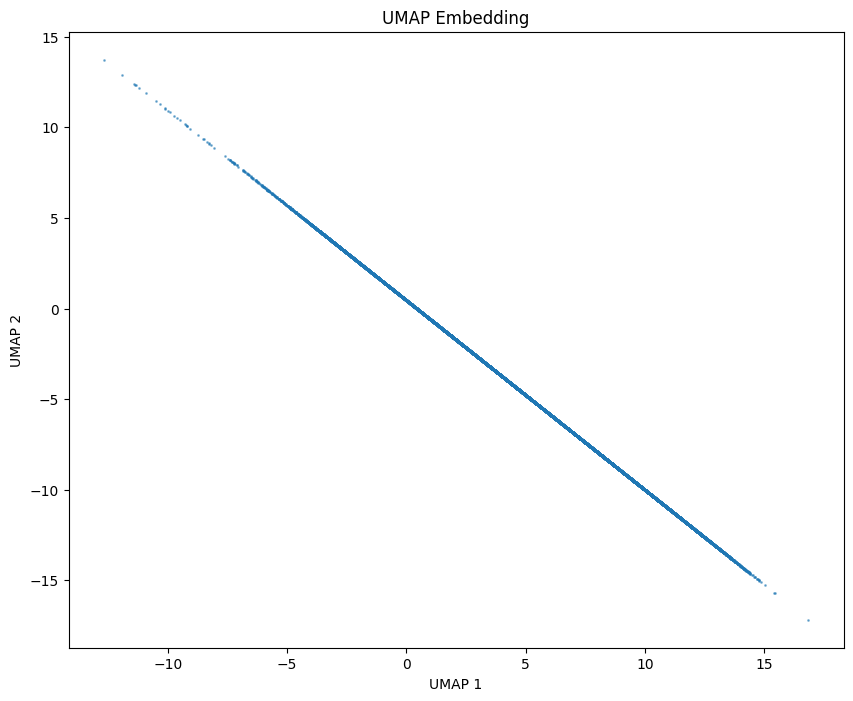

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.5)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Embedding")
plt.show()

In [ ]:
path = "./umap_embeder.pkl"
pumap.save(path)

Pickled PUMAP object at ./umap_embeder.pkl


In [17]:
# Loading
pumap = load_pumap(path)

Loading PUMAP object from pickled file.
